# Neccessary imports and enabling drive

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab import drive
from google.colab import files
from PIL import Image
import os
from google.colab import output

# GPU Configuration

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: Tesla T4


# Upload images for train and testset
Press the upload button under the cell to upload the images. The code assumes that image names indicate the labels. If the image name starts with the letter 'p', then it's considered a pothole image.

In [3]:
train_folder_path = '/content/trainset'
validation_folder_path = '/content/validationset'
test_folder_path = '/content/testset'

#create trainset folder if one doesn't exist
if not os.path.exists(train_folder_path):
    os.makedirs(train_folder_path)
    print(f"Directory '{train_folder_path}' created.")

#upload files into trainset
print("Upload Trainset")
uploaded_trainset = files.upload()
for filename, file_content in uploaded_trainset.items():
    file_path = os.path.join(train_folder_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(file_content)
output.clear()
print("Trainset successfully uploaded")
# Delete the files from the root directory
for filename in uploaded_trainset.keys():
    if os.path.exists(filename):
        os.remove(filename)

#create validationset folder if one doesn't exist
if not os.path.exists(validation_folder_path):
    os.makedirs(validation_folder_path)
    print(f"Directory '{validation_folder_path}' created.")

#upload files into validationset
print("Upload validationset")
uploaded_validationset = files.upload()
for filename, file_content in uploaded_validationset.items():
    file_path = os.path.join(validation_folder_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(file_content)
output.clear()
print("Validationset successfully uploaded")
# Delete the files from the root directory
for filename in uploaded_validationset.keys():
    if os.path.exists(filename):
        os.remove(filename)

#create testset folder if one doesn't exist
if not os.path.exists(test_folder_path):
    os.makedirs(test_folder_path)
    print(f"Directory '{test_folder_path}' created.")

#upload files into testset
print("Upload Testset")
uploaded_testset = files.upload()
for filename, file_content in uploaded_testset.items():
    file_path = os.path.join(test_folder_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(file_content)
# Delete the files from the root directory
for filename in uploaded_testset.keys():
    if os.path.exists(filename):
        os.remove(filename)
output.clear()
print("Testset successfully uploaded")

Testset successfully uploaded


# Preprocess images
Make sure pothole image names start with p

In [4]:
def filter_images(folder_path):
    # List all files in the 'trainset' directory
    file_list = os.listdir(folder_path)

    # Iterate through the files in the directory
    for filename in file_list:
        file_path = os.path.join(folder_path, filename)

        # Check if the file is an image (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image using OpenCV
            image = cv2.imread(file_path)

            #TODO
            filtered_image = image

            # Save the grayscale image with the same filename
            cv2.imwrite(file_path, filtered_image)

train_folder_path = '/content/trainset'
filter_images(train_folder_path)
validation_folder_path = '/content/validationset'
filter_images(validation_folder_path)
test_folder_path = '/content/testset'
filter_images(test_folder_path)

# Convert processed images to normalised tensors with labels

In [5]:
trainset_path = '/content/trainset'
validationset_path = '/content/validationset'
testset_path = '/content/testset'

# Define a transform to apply to the images (adjust the transformations as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

def load_images_from_folder(folder_path):
    image_tensors = []
    labels = []
    for filename in os.listdir(folder_path):
        #Get the labels
        if filename[0]=="p":
            labels.append(1)
        else:
            labels.append(0)
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            # Read the image using OpenCV
            image = cv2.imread(img_path)
            # Convert NumPy array to PIL image
            pil_image = Image.fromarray(image)
            # Apply transformations
            pil_image = transform(pil_image)
            image_tensors.append(pil_image)
    return image_tensors, labels

# Load images from trainset and testset folders
trainset_images, trainset_labels = load_images_from_folder(trainset_path)
validationset_images, validationset_labels = load_images_from_folder(validationset_path)
testset_images, testset_labels = load_images_from_folder(testset_path)

# Convert the lists of tensors into a single tensor
trainset_tensor = torch.stack(trainset_images)
validationset_tensor = torch.stack(validationset_images)
testset_tensor = torch.stack(testset_images)

# Print the shape of the resulting tensors
print("Trainset tensor shape:", trainset_tensor.shape)
print("Validationset tensor shape:", validationset_tensor.shape)
print("Testset tensor shape:", testset_tensor.shape)

#set batch size
batch_size = 4 #TODO
# Create DataLoader for training and testing
train_dataset = TensorDataset(trainset_tensor, torch.tensor(trainset_labels))
validation_dataset = TensorDataset(validationset_tensor, torch.tensor(validationset_labels))
test_dataset = TensorDataset(testset_tensor, torch.tensor(testset_labels))
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Trainset tensor shape: torch.Size([20, 3, 224, 224])
Validationset tensor shape: torch.Size([20, 3, 224, 224])
Testset tensor shape: torch.Size([20, 3, 224, 224])


# Model

In [8]:
# Define a simple CNN model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x

model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

# Training and Validation

Epoch 0 completed.
Epoch 10 completed.
Epoch 20 completed.


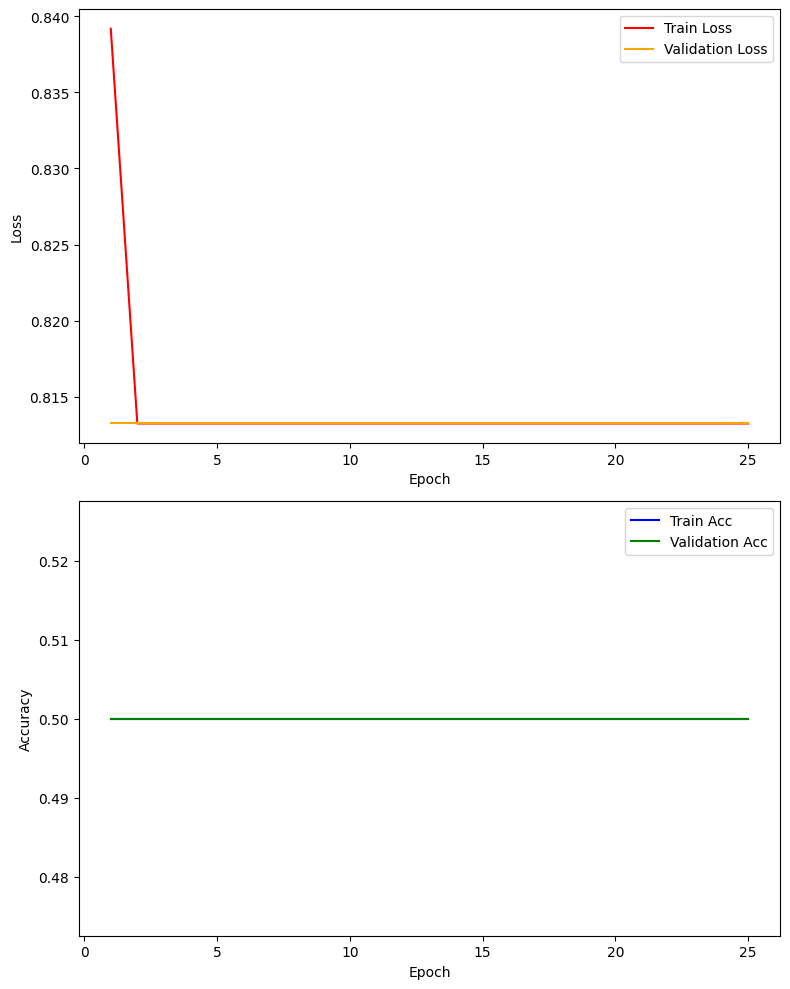

In [9]:
#TODO define number of epochs
num_epochs = 25
#arrays for the graphs
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

#training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0

    #model to training mode
    model.train()

    for images, labels in train_loader:
        #move to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        #clear gradients
        optimizer.zero_grad()

        #getting the loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward pass and optimization
        loss.backward()
        optimizer.step()

        #get training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    #get the training losses and accuracies to respective arrays
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #don't affect learning
    with torch.no_grad():
        for images, labels in validation_loader:
            #data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            #getting the loss
            outputs = model(images)
            loss = criterion(outputs, labels)

            #compute the validation loss and accuracy
            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            validation_correct += (predicted == labels).sum().item()
            validation_total += labels.size(0)

    #get the valiadtion loss and accuracy
    validation_loss = validation_loss / len(validation_loader.dataset)
    validation_accuracy = validation_correct / validation_total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    if epoch%10==0:
        print("Epoch "+str(epoch)+" completed.")


#loss graph
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
ax1.plot(range(1, num_epochs+1), train_losses, color="red")
ax1.plot(range(1, num_epochs+1), validation_losses, color="orange")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')
ax1.legend(('Train Loss', 'Validation Loss'))

#accuracy graph
ax2.plot(range(1, num_epochs+1), train_accuracies, color="blue")
ax2.plot(range(1, num_epochs+1), validation_accuracies, color="green")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')
ax2.legend(('Train Acc', 'Validation Acc'))

fig.tight_layout()
plt.show()


PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

# Testing loop

In [10]:
#don't affect learning
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0, 1]
    n_class_samples = [0, 1]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 50.0 %
